In [5]:
# eCommerce Project--------

'''
Q1. Some customers didn't write a review. But why are they happy or dissatisfied?
Q2. With purchase date information, predict the future sales information. What is the expected
Revenue for 2019? What are the factors that you might want to influence which may increase
revenue in 2019?
Q3. Identify delivery performance and find ways to optimize delivery times.
Q4. Discover the product categories that are more prone to customer dissatisfaction.
Q5. There are 71 product categories. However, the ecommerce platform wants to optimize their
number of product categories and want to reduce by 75%. How will they do that and which all will
be the categories that they should concentrate?
'''


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy import stats
from datetime import datetime

In [12]:
'''
Getting the Data and Cleaned it
'''
order_items_df = pd.read_csv("C:/Users/dubey/OneDrive/Desktop/Datasets/OnlineRetail-master/OnlineRetail-master/order_items.csv")
#Display all the column names-
print("order csv file :\n",list(order_items_df.columns))


order csv file :
 ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


In [14]:
# Required columns:
order_items_df = order_items_df[['order_id','product_id','price']]

In [16]:
product_df = pd.read_csv("C:/Users/dubey/OneDrive/Desktop/Datasets/OnlineRetail-master/OnlineRetail-master/products.csv")
#Display all the column names-
print("product csv file :\n",list(product_df.columns))

product csv file :
 ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [18]:
# Required columns:
product_df = product_df[['product_id','product_category_name']]

In [22]:
cat_df = pd.read_csv("C:/Users/dubey/OneDrive/Desktop/Datasets/OnlineRetail-master/OnlineRetail-master/product_category_name.csv")
#Display all the column names-
print("product category csv file :\n",list(cat_df.columns))

product category csv file :
 ['1 product_category_name', '2 product_category_name_english']


In [24]:
#let's rename the column names
cat_df = cat_df.rename(columns ={'1 product_category_name':'product_category_name',
'2 product_category_name_english':'product_category'})
print("After rename the columns name:\n",list(cat_df.columns))

After rename the columns name:
 ['product_category_name', 'product_category']


In [32]:
#Final dataset - merge tab1 and tab2
data = pd.merge(order_items_df,product_df, on='product_id',how='left')
#Now merge with category to get English Category
data = pd.merge(data,cat_df, on='product_category_name',how='left')



In [28]:
#check for missing data precentage list-
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{}-{}%'.format(col,round(pct_missing*100)))
#product category name - 1% lets create a new category called unknown
data['product_category'] = data['product_category'].fillna('Unknown')
#check if all rows hav been accounted
#if not then merge didn't happen correctly
print("Number of rows:\n\n order items[{}],\n\n MergedData[{}]".format(order_items_df.count(),data.count()))

order_id-0%
product_id-0%
price-0%
product_category_name-1%
product_category-0%
Number of rows:

 order items[order_id      112650
product_id    112650
price         112650
dtype: int64],

 MergedData[order_id                 112650
product_id               112650
price                    112650
product_category_name    111047
product_category         112650
dtype: int64]


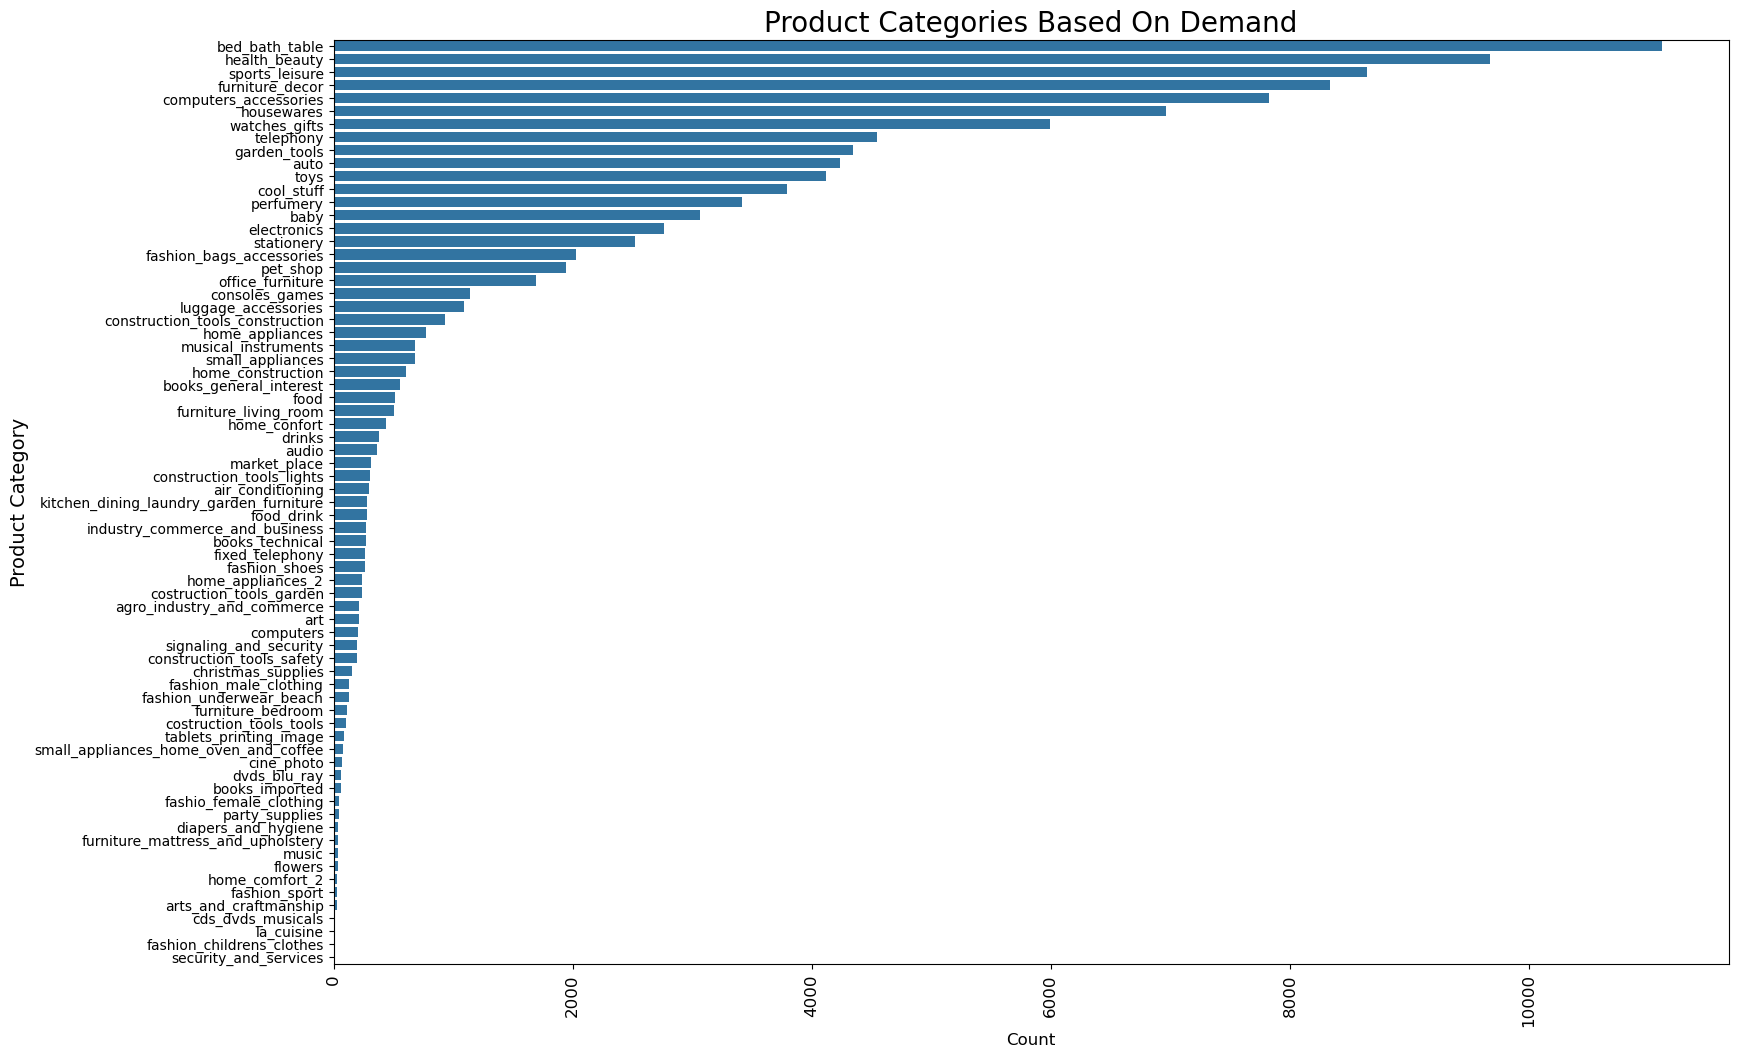

In [77]:
#Analyzing using Pareto

df=data[['price','product_category']]
df.set_index(data['product_category'])
 #Initially test with small dataset to see what you get
# df = df.head (100) #review with smaller dataset
 #Analysis 1: What is the most in demand product category?
plt.figure(figsize=(18,12))
sns.countplot (df['product_category'], order = df ['product_category'].value_counts().index)
plt.title('Product Categories based on Demand'.title(), fontsize=20)
plt.ylabel('Product Category'.title(), fontsize=14)
plt.xlabel('count'.title(), fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=10)
plt.show()

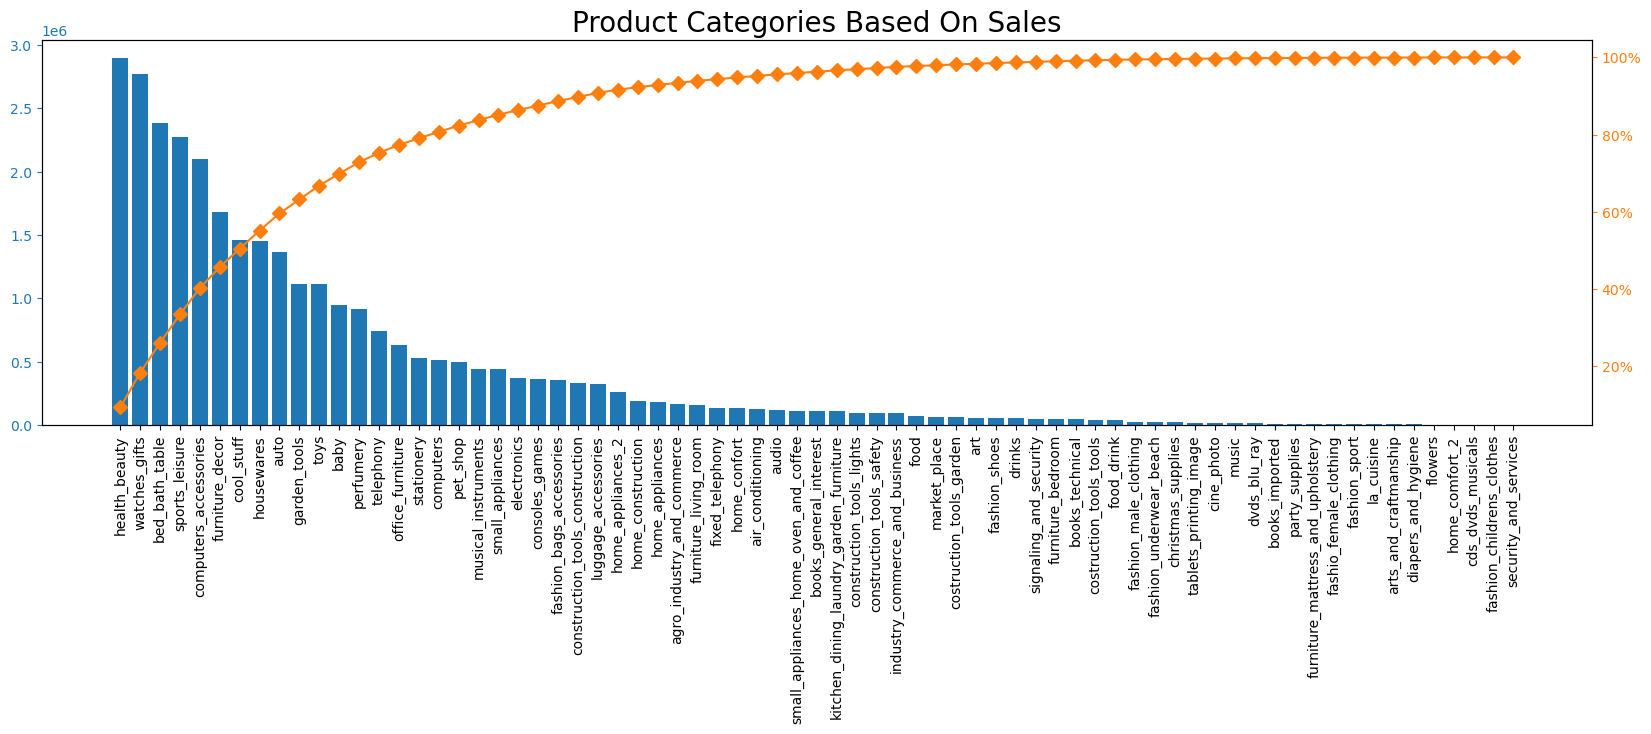

In [79]:
#2. which categories generates high sales-pareto
# Sort the values in descending order
quant_variable = df['price']
by_variable = df['product_category']
column = 'price'
group_by = 'product_category'
df = df.groupby (group_by) [column].sum().reset_index()
df =df.sort_values (by=column,ascending=False)
df["cumpercentage"] = df[column].cumsum()/df[column].sum()*100
fig, ax = plt.subplots (figsize=(20,5))
ax.bar(df[group_by], df[column],color="C0")
ax2= ax.twinx()
ax2.plot (df[group_by], df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="x", rotation=90)
ax.tick_params (axis="y",colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.title('Product Categories based on sales'.title(), fontsize=20)
plt.show()

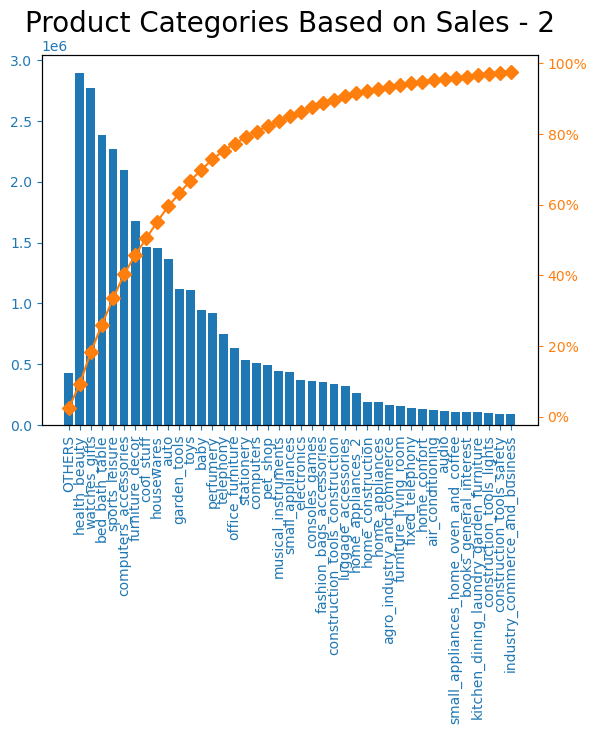

In [81]:
#variation 2
#Plotting above graph with only top 40 categories, rest as Other categories
total = quant_variable.sum()
# Group by the desired category and sum the quantitative variable
df = df.groupby(group_by)[column].sum().reset_index()

#Sort values in descending order
df = df.sort_values(by=column, ascending=False)
# Calculate cumulative percentage
df["cumpercentage"] = df[column].cumsum() / df[column].sum() * 100
thresold = df[column].cumsum()/5

# Select top 40 categories
df_above_threshold = df.iloc[:40]

#Calculate the sum of remaining categories (below top 40)
sum_other = total - df[column].sum()
restbarcumsum = 100 - df_above_threshold['cumpercentage'].max ()
# Create a new row for the 'OTHERS' category
rest = pd.Series (['OTHERS',sum_other,restbarcumsum],index=[group_by,column, 'cumpercentage'])
# Add 'OTHERS' row to the DataFrame
df = pd.concat([df_above_threshold, rest.to_frame().T], ignore_index=True)
# Set the category names as the index
df.index = df[group_by]
df = df.sort_values(by='cumpercentage', ascending=True)
fig, ax = plt.subplots()
ax.bar(df.index, df[column], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="x", colors="C0", labelrotation=90)
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.title('Product Categories Based on Sales - 2', fontsize=20)
plt.show()

In [85]:
order_df = pd.read_csv("C:/Users/dubey/OneDrive/Desktop/Datasets/OnlineRetail-master/OnlineRetail-master/orders.csv")
'''
We will evaluate the number of days taken to deliver an Order.
We will see two columns values from orders table.
order_purchase_timestamp, order_delivered_customer_date and the difference between them.
'''
#Display all the columns-
print(list(order_df.columns))

['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


In [87]:
# Convert the 'order_delivered_customer_date' and 'order_purchase_timestamp' columns to datetime format
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df['order_delivered_customer_date'])
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])

# Calculate the delivery days by finding the difference between delivery date and purchase date
order_df['delivery_days'] = (order_df['order_delivered_customer_date'] - order_df['order_purchase_timestamp']).dt.days

# Drop any rows with missing delivery days
order_df = order_df.dropna(subset=['delivery_days'])

C:\Users\dubey\AppData\Local\Temp\ipykernel_17640\81447481.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_df['delivery_days'].value_counts().sort_values(ascending=False).head(30).index,


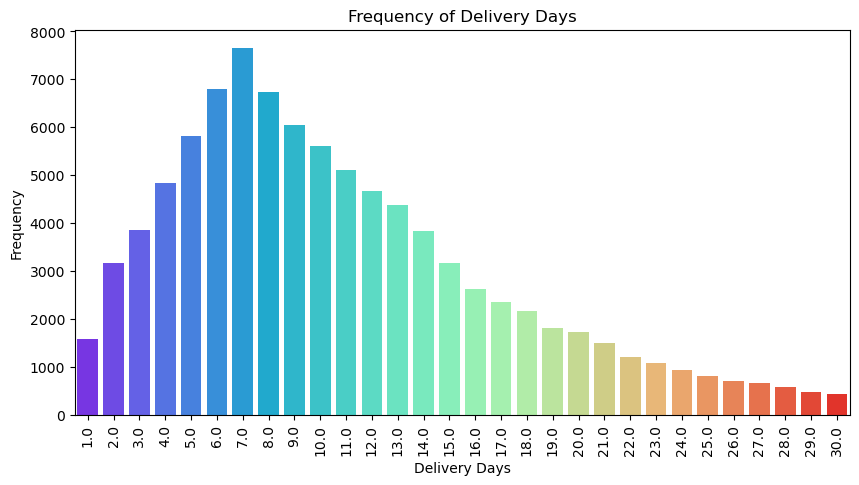

In [89]:
# Analyze the frequency of delivery days
plt.figure(figsize=(10, 5))
colormap = "rainbow"
sns.barplot(x=order_df['delivery_days'].value_counts().sort_values(ascending=False).head(30).index,
            y=order_df['delivery_days'].value_counts().sort_values(ascending=False).head(30).values,palette=colormap)
plt.xlabel('Delivery Days')
plt.ylabel('Frequency')
plt.title('Frequency of Delivery Days')
plt.xticks(rotation=90)
plt.show()

In [91]:
# Display basic Information of delivery days
print("Info of Delivery Days:\n",order_df['delivery_days'].describe())
print(f'\nMean Value of Delivery Days: {order_df['delivery_days'].mean():.1f}')
print(f'Median Value of Delivery Days: { order_df['delivery_days'].median()}')
print(f'Mode Value of Delivery Days: {stats.mode(order_df['delivery_days'])}')
print(f'Standard Deviation in Delivery Days: {order_df['delivery_days'].std():.1f}')


Info of Delivery Days:
 count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_days, dtype: float64

Mean Value of Delivery Days: 12.1
Median Value of Delivery Days: 10.0
Mode Value of Delivery Days: ModeResult(mode=7.0, count=7653)
Standard Deviation in Delivery Days: 9.6


In [93]:
'''
We will see top reasons for positive reviews and negative reviews.
We can use the NLP concept to analyze a text data (customer Reviews). We will analyze 
the review_comment data in the order_reviews.csv and we will pick top 3 reasons 
why customers like or dislike a product.
'''

'\nWe will see top reasons for positive reviews and negative reviews.\nWe can use the NLP concept to analyze a text data (customer Reviews). We will analyze \nthe review_comment data in the order_reviews.csv and we will pick top 3 reasons \nwhy customers like or dislike a product.\n'

In [95]:

#Prepare the date for the analysis--------

order_rev_df = pd.read_csv("C:/Users/dubey/OneDrive/Desktop/Datasets/OnlineRetail-master/OnlineRetail-master/order_reviews.csv")
print(list(order_rev_df.columns))
# Convert the 'review_creation_date' and 'review_answer_timestamp' columns to datetime format
order_rev_df['review_creation_date'] = pd.to_datetime(order_rev_df['review_creation_date'])
order_rev_df['review_answer_timestamp'] = pd.to_datetime(order_rev_df['review_answer_timestamp'])
#merge orders and reviews
reviews = pd.merge(order_df,order_rev_df,on='order_id',how='left')
reviews['order_id'].count()
print("columns count of order and reviews:\n",reviews.count())

['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
columns count of order and reviews:
 order_id                         97013
customer_id                      97013
order_status                     97013
order_purchase_timestamp         97013
order_approved_at                96999
order_delivered_carrier_date     97012
order_delivered_customer_date    97013
order_estimated_delivery_date    97013
delivery_days                    97013
review_id                        97013
review_score                     97013
review_comment_title             11321
review_comment_message           39754
review_creation_date             97013
review_answer_timestamp          97013
dtype: int64


In [97]:
#Remove unused columns
reviews.drop(columns=['order_id','customer_id','review_id','review_comment_title',
'order_estimated_delivery_date','order_delivered_carrier_date','order_approved_at'],inplace=True)
print("Afetr drop unused columns:\n",reviews.count())

Afetr drop unused columns:
 order_status                     97013
order_purchase_timestamp         97013
order_delivered_customer_date    97013
delivery_days                    97013
review_score                     97013
review_comment_message           39754
review_creation_date             97013
review_answer_timestamp          97013
dtype: int64


97013 reviews
First: 2016-10-06 00:00:00
Last: 2018-08-31 00:00:00
5Star:58.9%
1Star:10.1%
Average:4.1%


C:\Users\dubey\AppData\Local\Temp\ipykernel_17640\1710798830.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot (


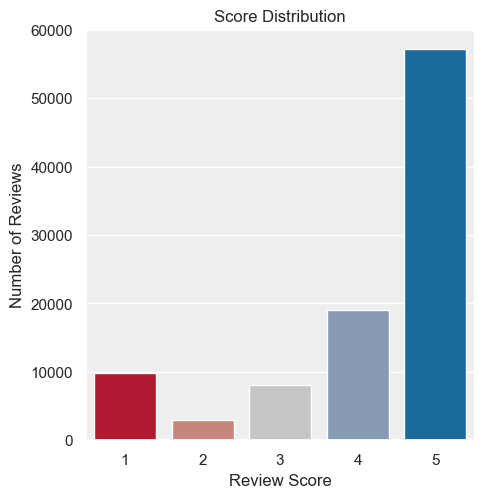

In [103]:
#Plot graphs to analyze the data--------
sns.set()
#5star : Blue to 1star : Red
Color_5s = "#0571b0"
Color_1s = "#ca0020"
Reviews_palette = sns.color_palette((Color_1s,"#d57b6f","#c6c6c6","#7f9abc",Color_5s))
# White background.......
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})
resize_plot = lambda : plt.gcf().set_size_inches(12,5)
p_5s = len(reviews[reviews['review_score']== 5])*100 / len(reviews)
p_1s = len(reviews[reviews['review_score']== 1])*100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
print(len(reviews),'reviews')
print('First:',first_dt)
print('Last:',last_dt)
print(f'5Star:{p_5s:.1f}%')
print(f'1Star:{p_1s:.1f}%')
print(f'Average:{avg_s:.1f}%')

# Score distribution as a categorical Bar Graphs
sns.catplot (
    x="review_score",
    kind="count",
    data= reviews ,
    palette = Reviews_palette
).set(
    xlabel = 'Review Score',
    ylabel= 'Number of Reviews'
);
plt.title("Score Distribution")
plt.show()

In [109]:
#Maximum reviews are 5 Star . It is interesting to observe that there's more 1 Star reviews than 2/3 Star reviews.



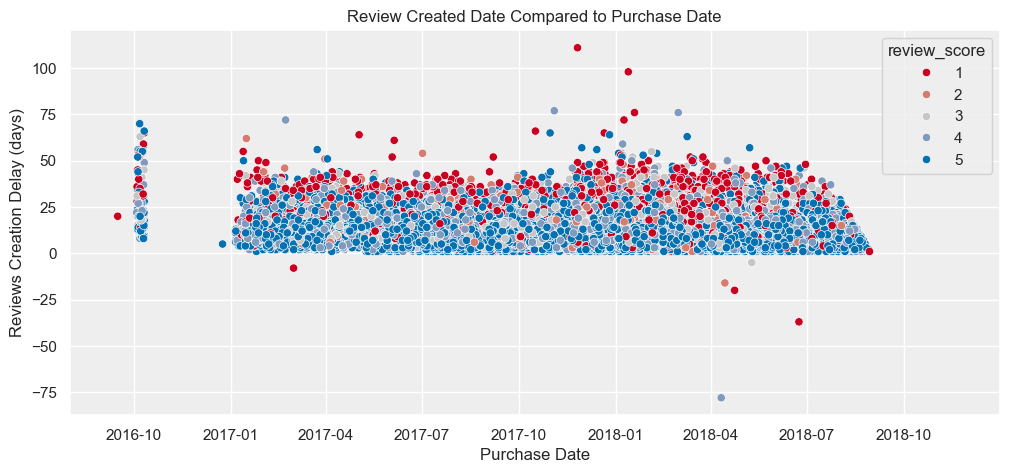

In [111]:

# Review Created Date Compared to Purchase Date
reviews['reviews_creation_delay'] = (reviews['review_creation_date']-
reviews['order_purchase_timestamp']).dt.days
sns.scatterplot(
    x= 'order_purchase_timestamp',
    y= 'reviews_creation_delay',
    hue='review_score',
    palette=Reviews_palette,
    data= reviews
).set(
    xlabel="Purchase Date",
    ylabel="Reviews Creation Delay (days)",
    xlim=(datetime(2016,8,1),datetime(2018,12,31))
);
resize_plot()
plt.title("Review Created Date Compared to Purchase Date")
plt.show()

In [119]:
'''The graph shows the spread of various reviews given from date of purchase . There are few 
reviews (mostly in October of 2018) shows reviews were given before purchase date. 
This could be because of error in the data)'''


'The graph shows the spread of various reviews given from date of purchase . There are few \nreviews (mostly in October of 2018) shows reviews were given before purchase date. \nThis could be because of error in the data)'

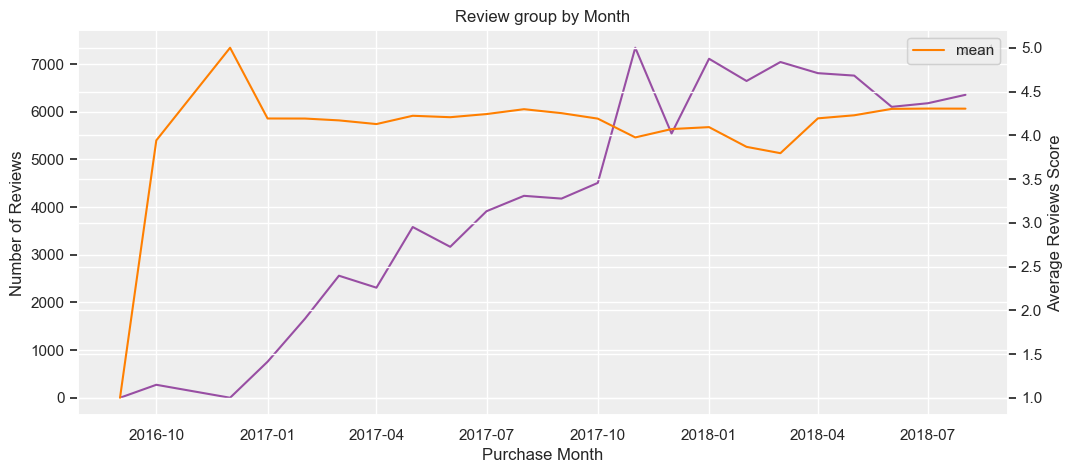

In [121]:
# Reviews by month using the order_purchase_timestamp column and plot a timeseries. Consider reviews created after purchase date
# Review group by month
reviews['year_month'] = reviews['order_purchase_timestamp'].dt.to_period('M')
reviews_timeseries = reviews [reviews['reviews_creation_delay']>0].groupby('year_month')['review_score'].agg(['count','mean'])
ax= sns.lineplot(
    x= reviews_timeseries.index.to_timestamp(),
    y= 'count',
    data= reviews_timeseries,
    color='#984ea3',
    label ='count'
)
ax.set(xlabel= 'Purchase Month', ylabel= 'Number of Reviews')
sns.lineplot(
x=reviews_timeseries.index.to_timestamp(),
y= 'mean',
data= reviews_timeseries,
ax= ax.twinx(),
color= '#ff7f00',
label= 'mean',
).set(ylabel = 'Average Reviews Score');
resize_plot()
plt.title("Review group by Month")
plt.show()

In [123]:
'''
There are 2 line - Mean line talks about the avergae reviews at the given point in time. Overall
score was close to 5 in Dec 2016 but it fell to below 4 in early 2018 but since then it has improved 
to go over 4 . The other line shows the total count of the reviews. We see that there was
a big jump in the number of reviews given during Nov and Dec of 2017.
'''

'\nThere are 2 line - Mean line talks about the avergae reviews at the given point in time. Overall\nscore was close to 5 in Dec 2016 but it fell to below 4 in early 2018 but since then it has improved \nto go over 4 . The other line shows the total count of the reviews. We see that there was\na big jump in the number of reviews given during Nov and Dec of 2017.\n'

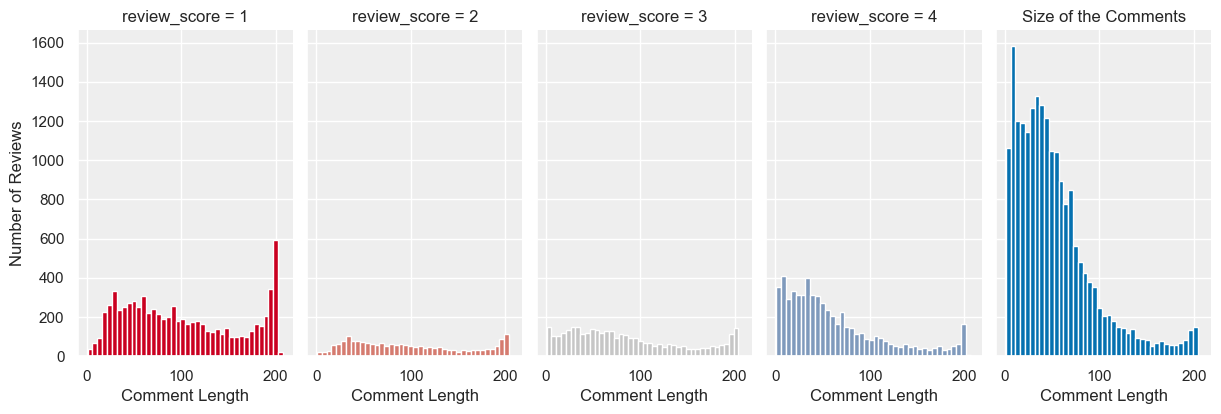

In [125]:
#Exploring Review Comments......
reviews['review_length']= reviews['review_comment_message'].str.len()
reviews[['review_score','review_length','review_comment_message']].head()
#Size of the comments
g=sns.FacetGrid(data=reviews,col='review_score',hue='review_score',palette=Reviews_palette)
g.map(plt.hist,'review_length',bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(12,5)
plt.title("Size of the Comments")
plt.show()

In [129]:

#Customers tend to write lengthier reviews when they are not satisfied.


C:\Users\dubey\AppData\Local\Temp\ipykernel_17640\3372631149.py:2: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.catplot(


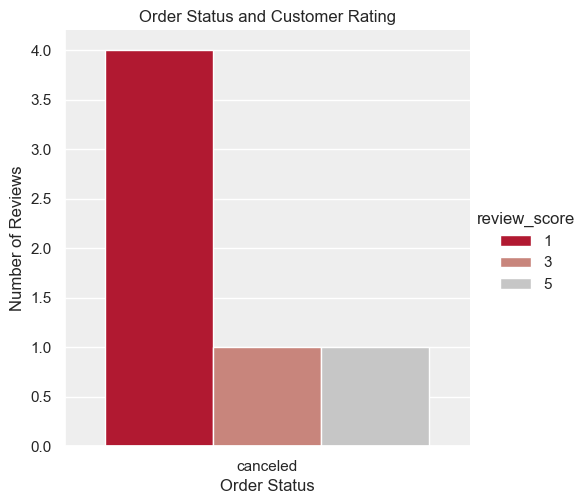

<Figure size 1200x500 with 0 Axes>

In [131]:
#Reviews Size and the Rating
ax = sns.catplot(
    x= 'order_status',
    kind='count',
    hue = 'review_score',
    data= reviews[reviews['order_status']!='delivered'],palette=Reviews_palette
).set(xlabel='Order Status', ylabel='Number of Reviews');
plt.title("Order Status and Customer Rating")
plt.show()
resize_plot()

In [133]:
#If we plot the review score distribution of orders that do not have a 'delivered' status,
#we can see the most of them have a 1 star rating.

In [135]:
#Perform NLP ANALYSIS--------

import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dubey\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dubey\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [137]:
# Remove accept / local dialect
def remove_accents(text):
    return unicodedata.normalize('NFKD',text).encode('ascii',errors='ignore').decode('utf-8')

#Remove stop words in Portuguese -----
stop_words = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
stop_words.remove('nao')

In [139]:
#Toeknize the comment- break a sentence into words
def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens =nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in stop_words and t.isalpha())
    return words

In [141]:
# Break the words into unigrams , bigrams and trigrams
def words_to_ngrams(words):
    unigrams,bigrams,trigrams =[],[],[]
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(''.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(''.join(trigram) for trigram in nltk.trigrams(comment_words))
    return unigrams,bigrams,trigrams

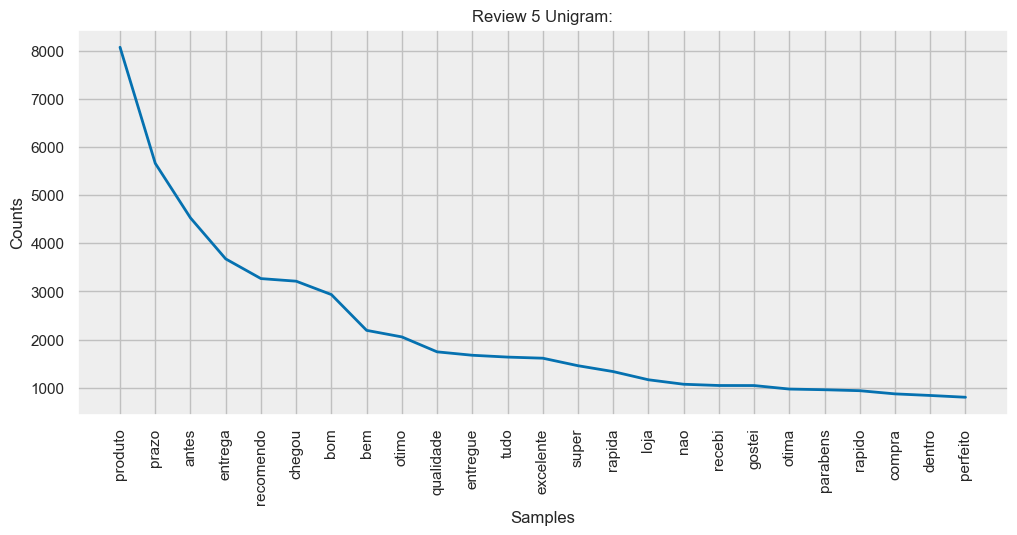

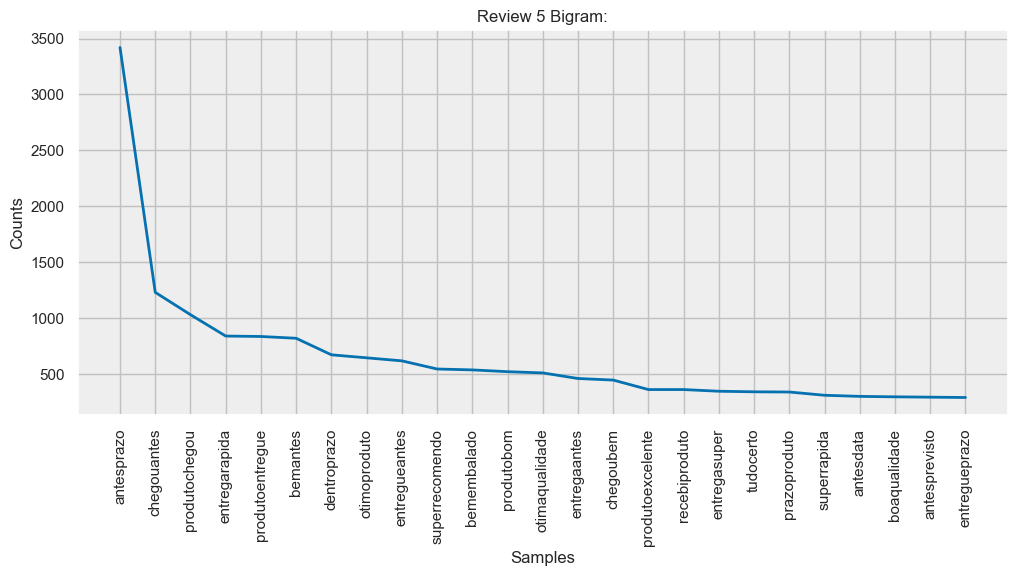

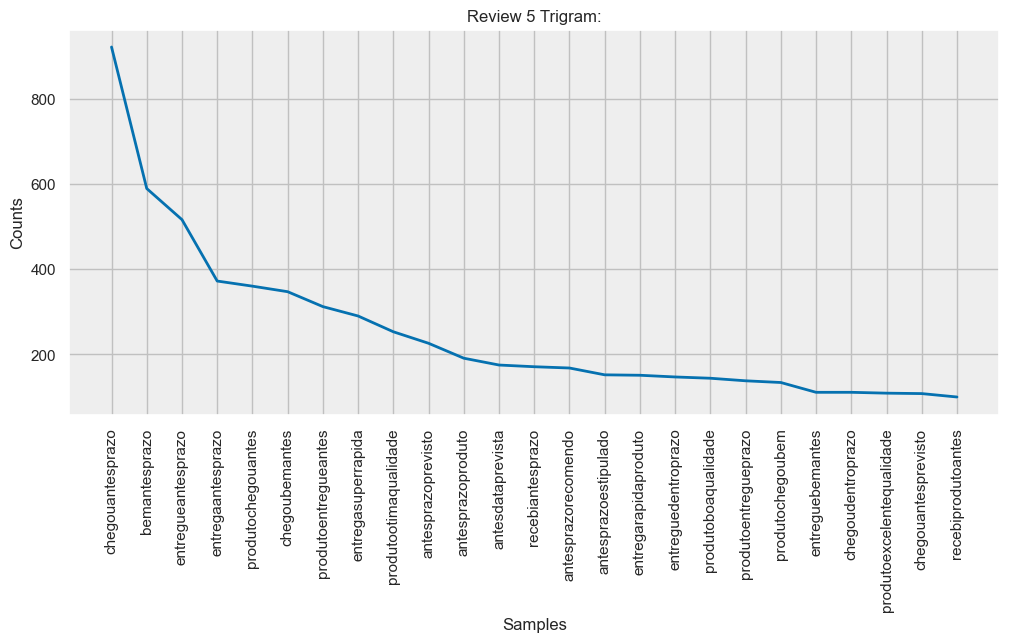

In [143]:
def plot_freq(tokens,color):
    resize_plot= lambda:plt.gcf().set_size_inches(12,5)
    resize_plot()
    nltk.FreqDist(tokens).plot(25,cumulative=False,color=color)
#Now go ahead with analysis
sns.set()
# 5 Star : Blue to 1 Star : Red
Color_5s = '#0571b0'
Color_1s = '#ca0020'
Reviews_palette= sns.color_palette((Color_1s,'#d57b6f','#c6c6c6','#7f9abc',Color_5s))
# white background---
sns.set_style('darkgrid',{'axes.facecolor':'#eeeeee'})
# Default figure size
resize_plot= lambda : plt.gcf().set_size_inches(12,5)

commented_reviews = reviews[reviews['review_comment_message'].notnull()].copy()
commented_reviews['review_comment_words'] =commented_reviews['review_comment_message'].apply(comments_to_words)
reviews_5s= commented_reviews[commented_reviews['review_score']==5]
reviews_1s= commented_reviews[commented_reviews['review_score']==1]

unigrams_5s,bigrams_5s,trigrams_5s =words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s,bigrams_1s,trigrams_1s =words_to_ngrams(reviews_1s['review_comment_words'])

# Now we will perform NLP analysis to understand it better
#step 1:  frequency distributions for 5 star n-grams
plot_freq(unigrams_5s,Color_5s)
plt.title('Review 5 Unigram:')
plt.show()
plot_freq(bigrams_5s,Color_5s)
plt.title('Review 5 Bigram:')
plt.show()
plot_freq(trigrams_5s,Color_5s)
plt.title('Review 5 Trigram:')
plt.show()

In [145]:
'''
Below are the frequency distribution for 5 star n-grams. We can identify 
some key topics customers enjoy about their experience:  
1. Fast delivery('chegou antes prazo','entrega rapida',entregue antes prazo','super rapida')
2. High quality goods('produto otima qualidade','otimo produto excelente','produto boa qualidade')
3. Good packaging ('bem embalado','produto cheguo bem')
'''

"\nBelow are the frequency distribution for 5 star n-grams. We can identify \nsome key topics customers enjoy about their experience:  \n1. Fast delivery('chegou antes prazo','entrega rapida',entregue antes prazo','super rapida')\n2. High quality goods('produto otima qualidade','otimo produto excelente','produto boa qualidade')\n3. Good packaging ('bem embalado','produto cheguo bem')\n"

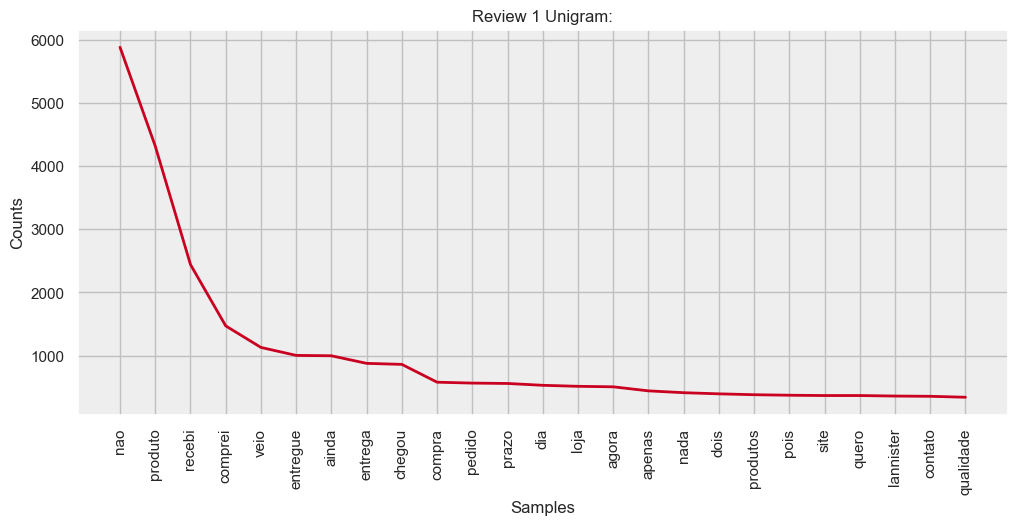

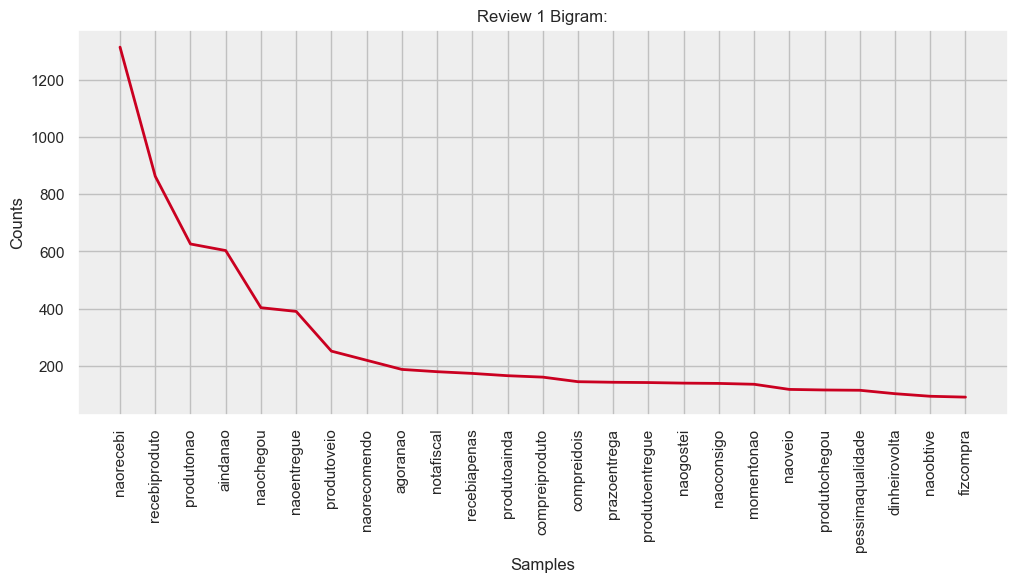

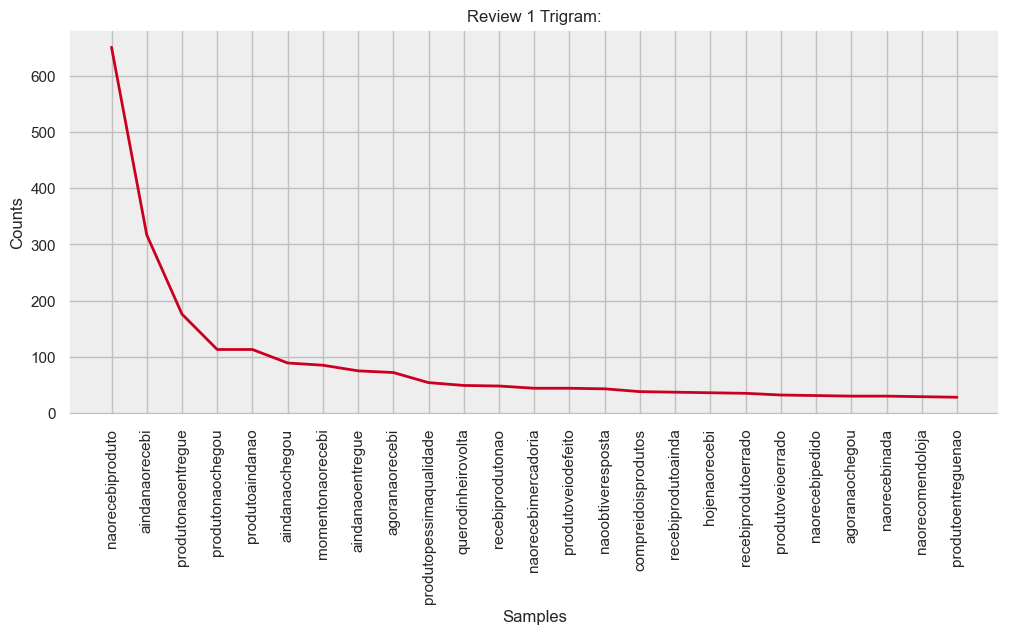

In [147]:
#step 2:  frequency distributions for 1 star n-grams
plot_freq(unigrams_1s,Color_1s)
plt.title('Review 1 Unigram:')
plt.show()
plot_freq(bigrams_1s,Color_1s)
plt.title('Review 1 Bigram:')
plt.show()
plot_freq(trigrams_1s,Color_1s)
plt.title('Review 1 Trigram:')
plt.show()

In [149]:
'''
Below are the frequency distribution for 1 star n-grams. We can identify 
some key topics customers dislike about their experience:
1. They didn't receive their goods yet('recebi produto ','ainda nao recebi',produto nao entregue','produto nao chegou','nao recebi mercadoria')
2.They want refund ('quero dinheiro volta')
3. Bad quality goods ('produto pessima qualidade',produto veio defeito')
4. they had some problem when purchasing 2 products ('comprei dois produtos')
'''

"\nBelow are the frequency distribution for 1 star n-grams. We can identify \nsome key topics customers dislike about their experience:\n1. They didn't receive their goods yet('recebi produto ','ainda nao recebi',produto nao entregue','produto nao chegou','nao recebi mercadoria')\n2.They want refund ('quero dinheiro volta')\n3. Bad quality goods ('produto pessima qualidade',produto veio defeito')\n4. they had some problem when purchasing 2 products ('comprei dois produtos')\n"

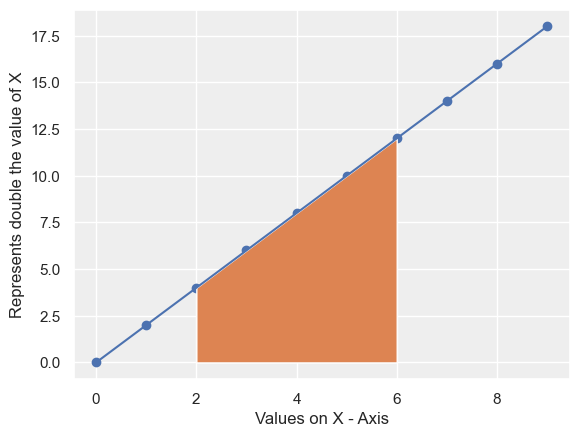

In [151]:
def is_in_interval(number, minimum,maximum):
    return minimum<= number <= maximum
# check whether a number falls within a specified interval : minimum and a maximum parameter.
x= range(0,10)
y= [2 * value for value in x]
where = [is_in_interval(value,2,6)for value in x]
plt.scatter(x,y)
plt.plot(x,y)
plt.fill_between(x,y, where=where)
plt.xlabel('Values on X - Axis')
plt.ylabel('Represents double the value of X')
plt.show()

In [155]:
'''Where will take following values in this example:
Where = [False, False, True, True, True, True, True, False, False, False]'''

'Where will take following values in this example:\nWhere = [False, False, True, True, True, True, True, False, False, False]'